<a href="https://colab.research.google.com/github/Jee-9/Study/blob/main/TPS09_H2O_Error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns

# load

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_path = '/content/drive/MyDrive/DATA/Kaggle_TPS09/train.csv'
test_path = '/content/drive/MyDrive/DATA/Kaggle_TPS09/test.csv'
solution_path = '/content/drive/MyDrive/DATA/Kaggle_TPS09/sample_solution.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
solution = pd.read_csv(solution_path)

In [4]:
train.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,0.59881,1.423200e+09,0.27240,9.455600,-0.050305,1938.300,8.6331,4.0607,26.8670,-1.180,10961.00,1.5397,135.3200,-1.49650,440.080,2.590100e+12,2.194200e+09,2968800.0,0.001431,13.3270,0.75050,18509.0,146820.0,-0.000276,1.090600e+16,1705.400,414.29,3.5392,1888.0,...,-0.001081,6.1244,1.231800e+11,275.9200,5308500.0,1704.000,5.022400e+10,53.3980,-2.2012,6871.0,3.8862,-0.00558,5252.100,166.690,1.60740,0.66534,7768.900,0.99662,1.125700e+11,2.2432,0.934160,0.65056,94569.0,21.471,8214.100,0.288010,0.097826,0.001071,1.412400e+09,0.11093,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,1.20930,3.334100e+09,0.28631,-0.012858,-0.019912,10.284,6.1872,1.0419,4.6404,31.877,123620.00,1.3951,125.8100,1.19890,136.450,9.098100e+09,4.004100e+10,1564000.0,0.000204,3.1074,1.50330,238000.0,21440.0,-0.001344,3.079400e+16,229.100,844.82,1.4680,4726.5,...,0.254100,6.9191,1.832400e+11,9.6510,32800.0,1480.600,2.300600e+10,44.0510,205.6900,4295.3,13.3880,0.46843,754.610,83.233,1.18900,29.55000,7343.700,0.99815,4.877700e+13,1.2708,-0.000969,5.29520,6779.0,227.720,34.342,0.340300,0.143370,0.049276,1.903200e+09,0.97673,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,0.38164,1.230300e+09,0.25807,2.455600,NaN,26.873,7.5463,1.9967,1.9526,817.760,-2948.70,2.0054,1.6826,1.19680,74.624,-3.273900e+10,5.718900e+10,11058.0,-0.003097,8.0241,1.13180,27940.0,862460.0,-0.002207,5.849100e+13,-897.840,NaN,1.3561,3063.4,...,0.260260,6.1052,1.013300e+11,357.2700,1476600.0,90.845,1.306200e+09,2.3731,391.3700,2965.3,NaN,0.49459,43.524,138.520,1.10790,0.91948,47.915,NaN,1.510500e+12,3.4663,0.560950,4.13090,95531.0,39.486,-83.148,0.084881,0.032222,0.001668,1.436500e+07,0.20102,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,1.10960,1.223100e+09,0.30944,10.370000,-0.106260,533.840,7.8490,1.0379,8.0030,12.349,-195.28,2.5598,92.1420,0.63789,1054.900,-1.204100e+10,5.187300e+12,1475400.0,1.036500,1.1903,0.98941,301200.0,NaN,-0.000007,-9.299200e+13,-10.818,1020.30,2.9553,3342.5,...,0.372830,1.5606,1.835400e+10,-3.4298,6485700.0,2120.000,3.081200e+10,34.0560,157.4300,3724.5,8.4211,0.40778,2971.200,204.700,-0.97998,9.94050,12011.000,0.99898,5.063400e+13,1.2261,0.250200,0.72974,373690.0,194.650,120.930,0.260710,0.234240,-0.002794,1.442300e+09,-0.01182,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,1.05310,2.634100e+09,0.29782,2.654800,NaN,1808.900,7.2783,3.9757,NaN,NaN,29520.00,3.4225,96.7250,0.79725,215.570,1.732600e+13,2.635200e+12,2161200.0,0.895470,6.8257,0.97413,142620.0,231350.0,0.001257,1.012500e+16,51.508,293.76,1.3351,3042.1,...,0.085690,1.5846,3.825200e+10,130.7000,102100.0,1951.800,1.142800e+10,58.5660,176.8300,1279.0,4.9662,0.47912,-70.278,10.887,1.14340,6.19120,197.470,NaN,1.574800e+13,1.0083,0.339530,13.48600,201300.0,38.842,324.000,0.238250,0.141550,0.002208,5.830700e+09,0.92739,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [8]:
print("train_null : ", train.isnull().sum().sum())
print("test_null : ", test.isnull().sum().sum())

train_null :  1820782
test_null :  936218


# Drop useless columns

In [4]:
# print(train.columns)
# print(test.columns)

target = train['claim']
train.drop(columns = ['id', 'claim'], inplace = True)
test.drop(columns = 'id', inplace = True)

# Visualization

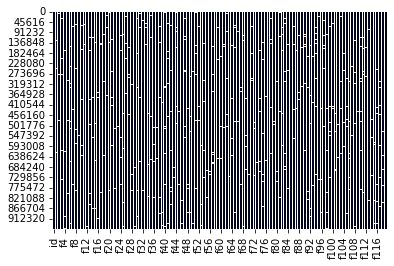

In [10]:
sns.heatmap(train.isnull(), cbar=False)

In [11]:
pip install missingno

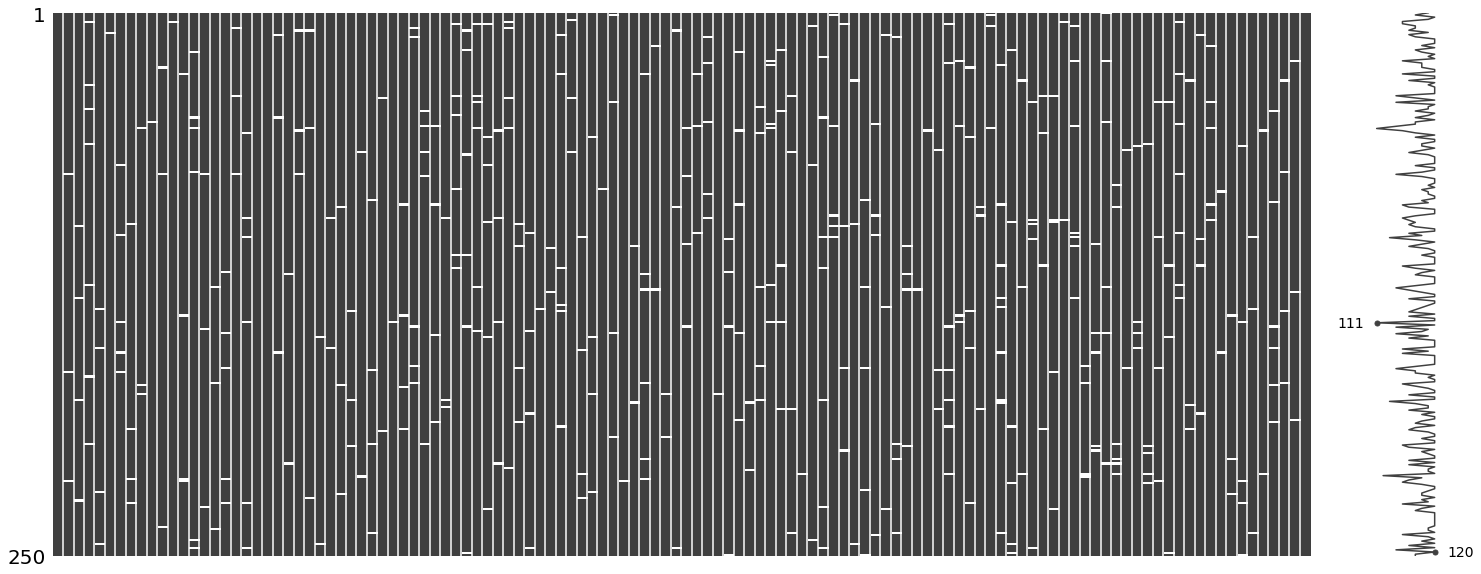

In [12]:
import missingno as msno
msno.matrix(train.sample(250))

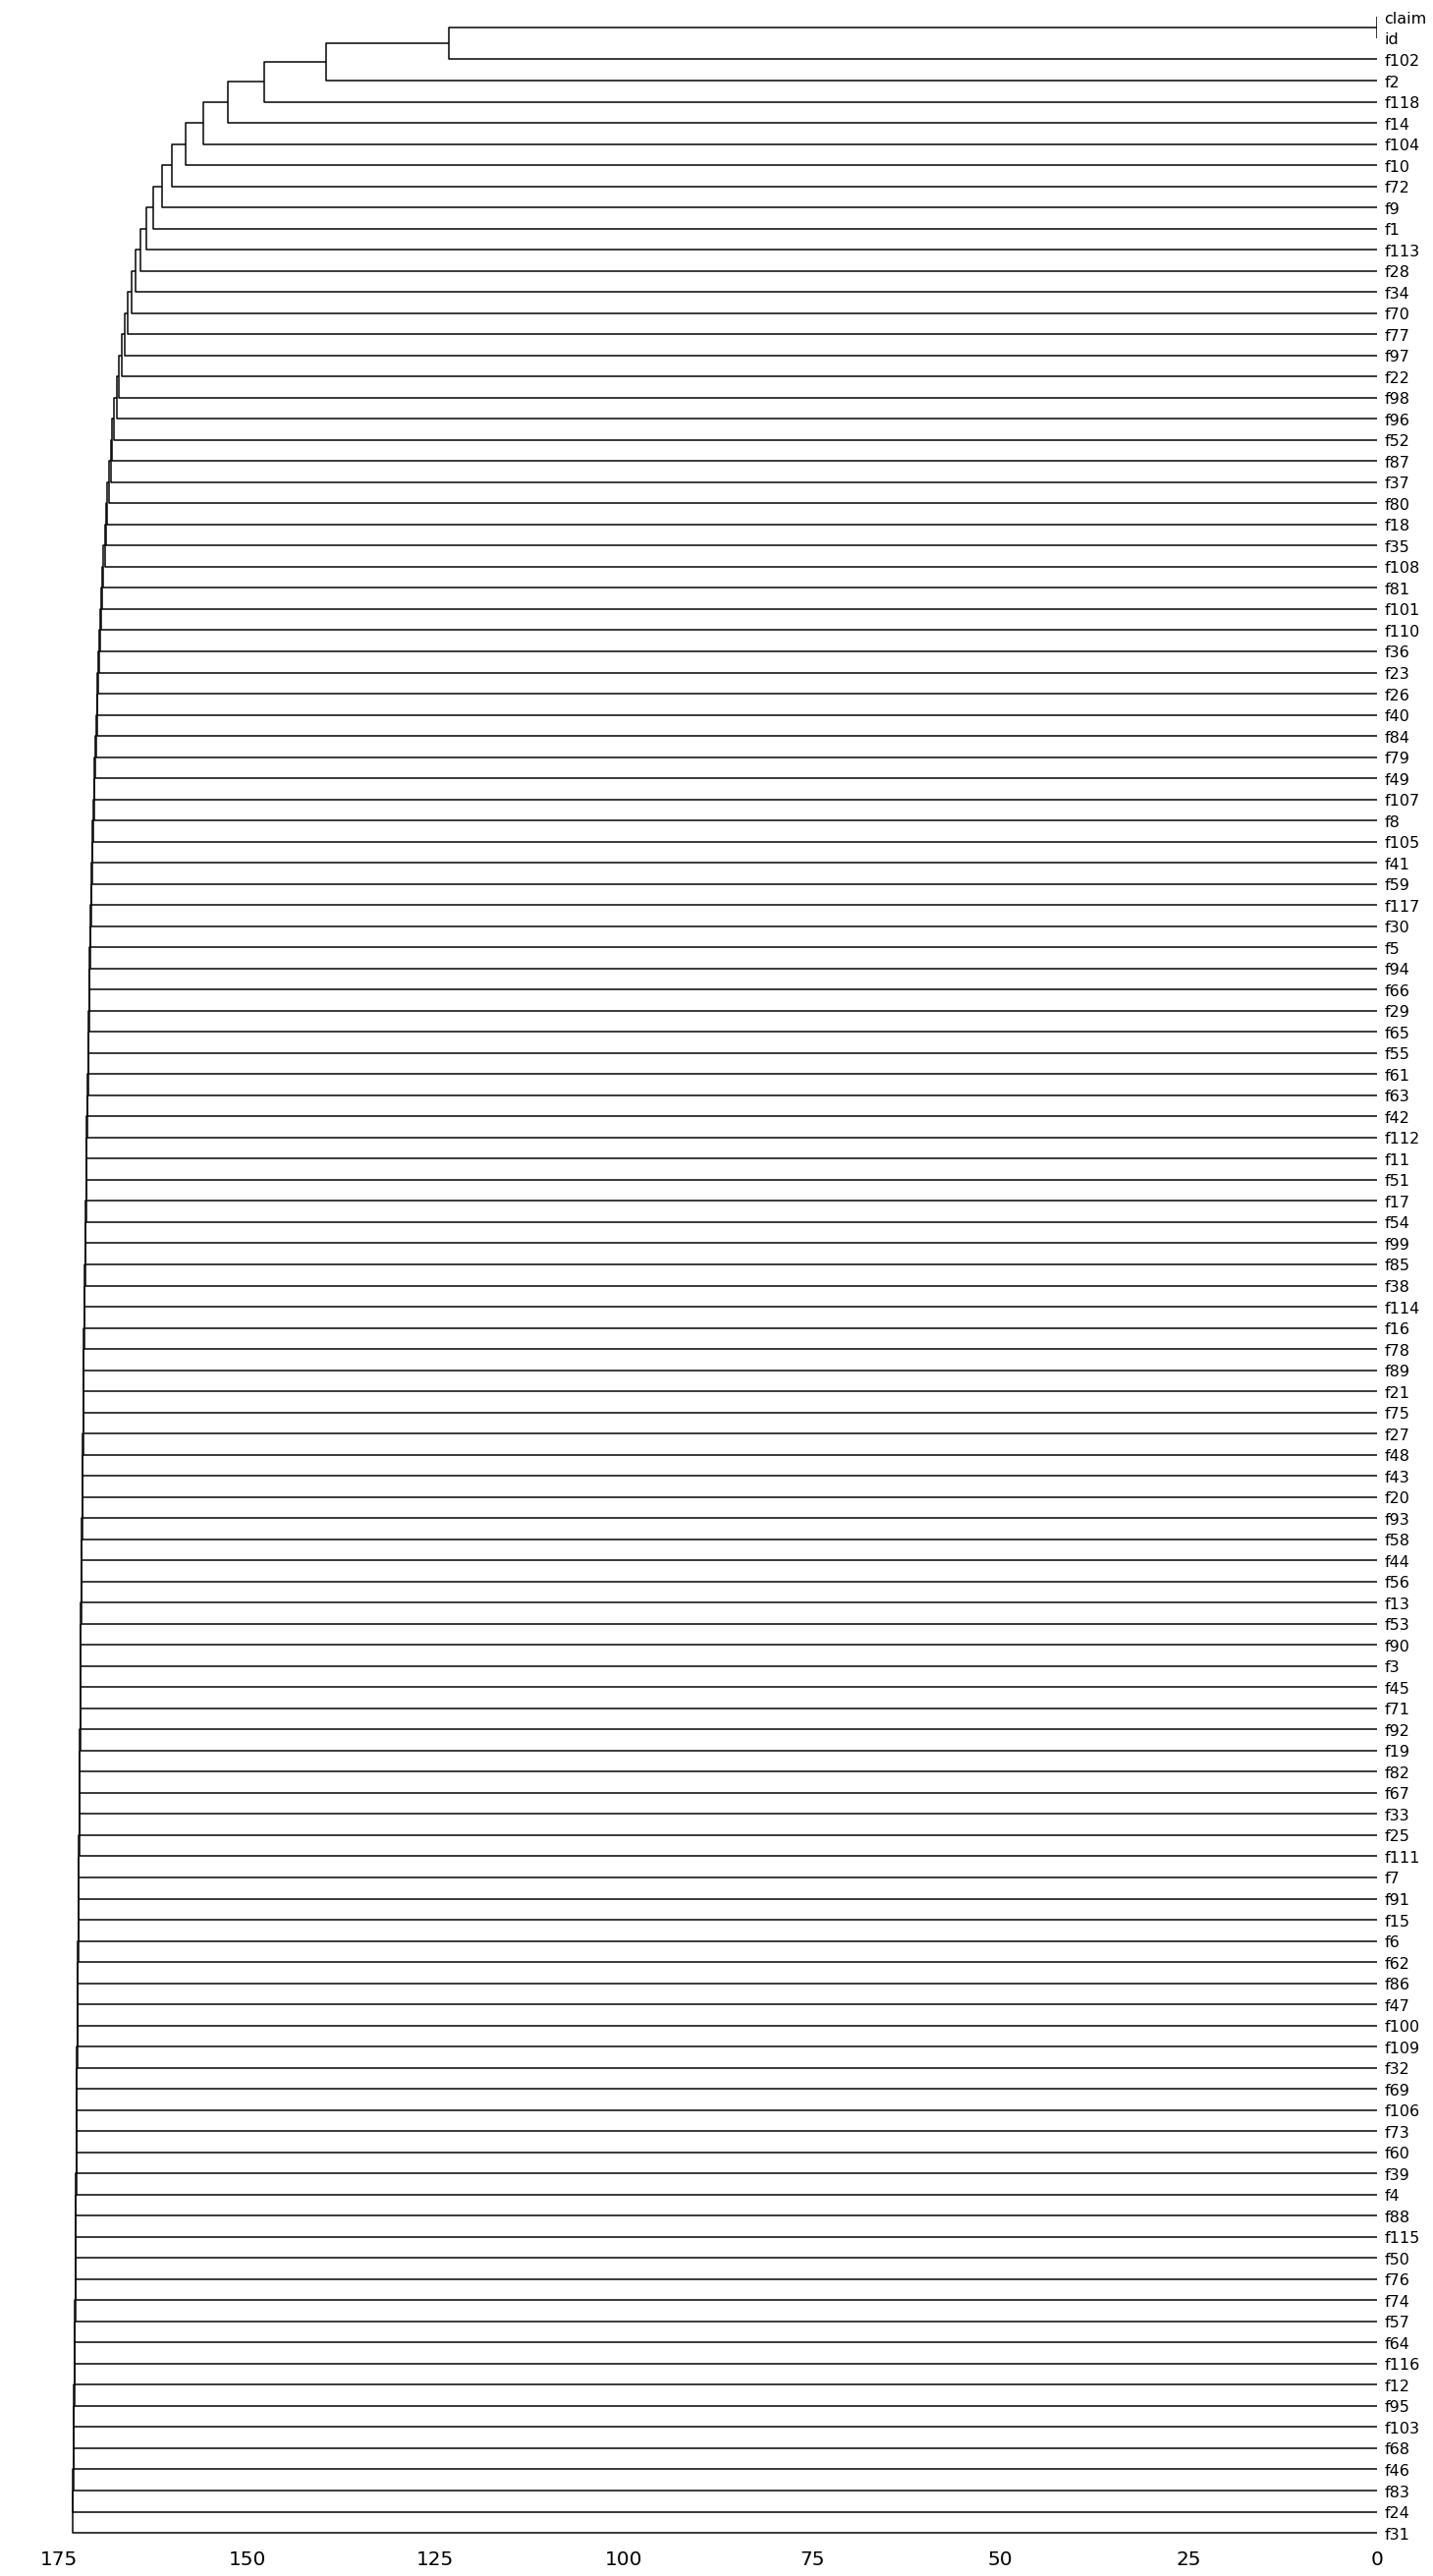

In [13]:
msno.dendrogram(train)

In [ ]:
# skewed 확인하기

features = train.columns
i = 1
plt.figure()

fig, ax = plt.subplots(9, 6, figsize = (28,28))
for f in features:
  plt.subplot(24, 5, i)
  sns.distplot(train[features], color = 'blue', kde = True, bins = 120, label = 'train')
  i += 1
plt.show()

# 헐 얘만 돌면 사용 가능한 RAM을 모두 사용한 후 세션이 다운되었다고 뜬다. 왜?

In [ ]:
# Outlier Detection



# Impute Missing Values

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')
tr_imputed = pd.DataFrame(imputer.fit_transform(train))

tr_imputed.columns = train.columns

# tr_imputed.isnull().sum().sort_values(ascending = False).to_frame().reset_index().head(50).T
tr_imputed.isnull().sum().sort_values(ascending = False).to_frame().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
index,claim,f118,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f30,f29,f28,f13,f1,f2,f3,f4,f5,f6,f7,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f91,f89,f61,f74,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f75,f88,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# AutoML H2O

In [2]:
!pip install requests
!pip install tabulate
!pip install "colorma>=0.3.8"
!pip install future

!pip uninstall h2o

!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

ERROR: Could not find a version that satisfies the requirement colorma>=0.3.8 (from versions: none)
ERROR: No matching distribution found for colorma>=0.3.8
Found existing installation: h2o 3.34.0.1
Uninstalling h2o-3.34.0.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h2o-3.34.0.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h2o/*
Proceed (y/n)? y
  Successfully uninstalled h2o-3.34.0.1
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
  Using cached h2o-3.34.0.1-py2.py3-none-any.whl


In [5]:
from sklearn.model_selection import train_test_split
import time
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,22 mins 35 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.1
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_unknownUser_4hluqx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.119 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [6]:
y = "claim"
tr_imputed = tr_imputed.drop(columns = 'id')

In [ ]:
# y = tr_imputed['claim']
# tr_imputed = tr_imputed.drop(columns = ['id', 'claim'])
x = list(tr_imputed.columns)

train, valid = train_test_split(tr_imputed,
                                test_size = 0.2,
                                shuffle = True)

h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

# For binary classification
# h2o_train[y] = h2o_train[y].asfactor()
# h2o_valid[y] = h2o_valid[y].asfactor()
# 데이터 중 라벨이 어떤 column에 해당하는지 알려주는 함수 .asfactor()

In [ ]:
x.remove(y)

In [22]:
# # H2O TypeError
# '''
# H2O is expecting a native Python int, but you are passing a numpy int64. 
# Try converting the numpy array into a list max_depth=np.arange(10,11,1).tolist()[0]'''

# sec_train_path = '/content/drive/MyDrive/DATA/Kaggle_TPS09/train.csv'
# sec_train = pd.read_csv(sec_train_path)
# sec_train.drop(columns = 'id')

In [ ]:
aml = H2OAutoML(stopping_metric = 'AUC', max_runtime_secs = MAX_MODEL_RUNTIME_SECS)
aml.train (x=x, y=y, training_frame = h2o_train, leaderboard_frame = h2o_valid)

In [ ]:
leaderboard = aml.leaderboard
performance = aml.leader.model_performance(h2o_valid)

model_id = aml.leader.model_id
accuracy = performance.accuracy()
precision = performance.precision()
recall = performance.recall()
F1 = performance.recall()
auc = performance.auc()
variable_importance = aml.leader.varimp()

print(model_id, accuracy, precision, recall, F1, auc, variable_importance)
print(performance)

In [ ]:
preds_h2o = aml.leader.predict(h2o_test)

In [ ]:
solution['claim'] = preds_h2o